In [1]:
# Image caption model using a method similar to ClipCap (Mokady et al., 2021)
# Dataset: flickr8k
# Image encoder: WinKawaks/vit-tiny-patch16-224
# Text decoder: distilgpt2
# Parameter count : 87.6M


import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoImageProcessor, ViTModel
from transformers import AutoTokenizer, AutoModelForCausalLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
from random import randint
import matplotlib.pyplot as plt
os.environ["TOKENIZERS_PARALLELISM"] = "false"


df = pd.read_csv("/kaggle/input/flickr8k/captions.txt", header=0)
print(df.head())

                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


In [2]:
# Image encoder
image_processor = AutoImageProcessor.from_pretrained("WinKawaks/vit-tiny-patch16-224")
image_encoder = ViTModel.from_pretrained("WinKawaks/vit-tiny-patch16-224")
for param in image_encoder.parameters():
    param.requires_grad = False
    
# Text decoder (DistilGPT-2)
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
text_decoder = AutoModelForCausalLM.from_pretrained("distilgpt2")

# Set up BOS, EOS, PAD
tokenizer.add_special_tokens({
    "bos_token": "<BOS>",
    "eos_token": "<EOS>",
    "pad_token": "<PAD>"
})
text_decoder.resize_token_embeddings(len(tokenizer))


# Caption model
class CaptionModel(nn.Module):
    def __init__(self, image_encoder, text_decoder):
        super().__init__()
        self.image_encoder = image_encoder
        self.prefix_mapper = nn.Linear(
            image_encoder.config.hidden_size, 
            text_decoder.config.hidden_size
        )
        self.text_decoder = text_decoder

    def forward(self, images, input_ids, attention_mask=None, labels=None):
        # Encode image → take CLS token
        img_feats = self.image_encoder(images).last_hidden_state[:, 0, :]  # [batch, 192]

        # Project into GPT2 hidden dim
        prefix = self.prefix_mapper(img_feats).unsqueeze(1)  # [batch, 1, 768]

        # Get decoder embeddings for input tokens
        inputs_embeds = self.text_decoder.transformer.wte(input_ids)  # [batch, seq_len, 768]

        # Concatenate prefix + text embeddings
        inputs_embeds = torch.cat([prefix, inputs_embeds], dim=1)  # [batch, seq_len+1, 768]

        # Pad attention_mask
        prefix_mask = torch.ones((attention_mask.size(0), 1), dtype=attention_mask.dtype, device=attention_mask.device)
        attention_mask = torch.cat([prefix_mask, attention_mask], dim=1)  # [batch, seq_len+1]

        # Shift labels (so they match text tokens only)
        if labels is not None:
            # pad one token at start for prefix
            dummy = torch.full((labels.size(0), 1), -100, dtype=labels.dtype, device=labels.device)
            labels = torch.cat([dummy, labels], dim=1)

        # Run decoder with custom inputs_embeds
        outputs = self.text_decoder(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            labels=labels
        )
        return outputs

    @torch.no_grad()
    def generate(self, images, tokenizer, max_length=32, device=device, do_sample=True, top_k=50):
        
        # Encode image → project into decoder space
        img_feats = self.image_encoder(images).last_hidden_state[:, 0, :]
        
        # Project into GPT2 hidden dim
        prefix = self.prefix_mapper(img_feats).unsqueeze(1)  # [batch, 1, 768]

        # Start with <BOS>
        bos = torch.tensor([tokenizer.bos_token_id], device=device).unsqueeze(0)
        bos_embeds = self.text_decoder.transformer.wte(bos)
        bos_embeds = bos_embeds.expand(prefix.size(0), -1, -1)

        # Concatenate prefix + BOS
        inputs_embeds = torch.cat([prefix, bos_embeds], dim=1)

        # Use Hugging Face generate()
        generated_ids = self.text_decoder.generate(
            inputs_embeds=inputs_embeds,
            max_length=max_length,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=do_sample,
            top_k=top_k
        )

        captions = [tokenizer.decode(ids, skip_special_tokens=True) for ids in generated_ids]
        return captions

# Build model
model = CaptionModel(image_encoder, text_decoder)
model.to(device)

# Load weights
if False:
    model.load_state_dict(torch.load("/kaggle/working/caption_model_30.pt"))
    print("Weights loaded")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [3]:
captions = [f"<BOS>{c}<EOS>" for c in df["caption"]]
encodings = tokenizer(
    captions,
    padding="max_length",
    truncation=True,
    max_length=31,  # max sequence length = 32 after prepending <CLS>
    return_tensors="pt"
)

class Flickr8kDataset(Dataset):
    def __init__(self, images, image_processor, encodings, img_dir="/kaggle/input/flickr8k/Images"):
        self.images = images
        self.img_dir = img_dir
        self.image_processor = image_processor
        self.inputs_ids = encodings['input_ids']
        self.attention_mask = encodings['attention_mask']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # --- Load image ---
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        image = image_processor(images=image, return_tensors="pt")
        image = image["pixel_values"].squeeze(0)
        
        input_ids = self.inputs_ids[idx]
        attention_mask = self.attention_mask[idx]

        return image, input_ids, attention_mask

dataset = Flickr8kDataset(df['image'].to_list(), image_processor, encodings)

In [4]:
# sanity check

images, input_ids, attention_mask = zip(*[dataset[i] for i in range(10)])
images = torch.stack(images).to(device)
input_ids = torch.stack(input_ids).to(device)
attention_mask = torch.stack(attention_mask).to(device)

outputs = model(images, input_ids, attention_mask=attention_mask, labels=input_ids)
print("Loss:", outputs.loss.item())
print("Logits shape:", outputs.logits.shape)

model.generate(
    images,
    tokenizer,
    do_sample = True
)

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Loss: 11.176520347595215
Logits shape: torch.Size([10, 32, 50260])


[' " 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1',
 " re in the ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '",
 ' from the old in a g of a g of a g of a g of a g of a g of a g of a g of a g',
 ' he to be a half. a. a. an. a. a. a. a. a. a. a. a. a.',
 ' he was to you in the very old old age of old age of old age of old old age of old age of old age of old age of',
 " the death in the service in the s. in the, a to the. was for a period with the dachar's cag. And",
 '., in a the day of that (p. 20) there was nothing so that the days a day and in a part the time the day',
 ' a. The death of Mah aur of dresher of a man about dresher, as is more of the day.\nHav',
 ' and her and the time of death. On the Therand "Sallah Mah-Sill Mah-Sill Mah-Sill Mah-',
 ' (SJ.)\nA.B. (re-in a-day)\nA.B. (re-in a-day']

In [ ]:
# hyperparameters
batch_size = 64
num_epochs = 30
lr = 1e-4
max_len = 32

# initialize optimizer and dataloader
optimizer = optim.AdamW(model.parameters(), lr=lr)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


# train
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in progress:
        images, input_ids, attention_mask = batch

        # Move text tensors
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        # Forward + loss
        outputs = model(images, input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Logging
        total_loss += loss.item()
        progress.set_postfix({"loss": loss.item()})

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")
    if (epoch+1)//10==0:
        torch.save(model.state_dict(), f"caption_model_{epoch+1}.pt")

In [ ]:
# load
if True:
    model.load_state_dict(torch.load("/kaggle/input/caption_model_30/pytorch/default/1/caption_model_30.pt"))
    print("Weights loaded")

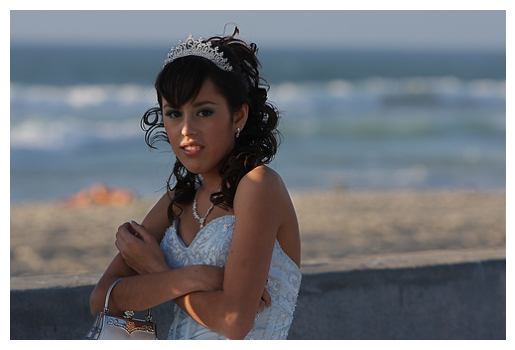

Reference label: a woman wear a fancy dress and tiara on a beach
Generated captions:
A woman dressed nicely stands on beach with a beautiful beach behind her .
A little girl with seish feet walks across the beach barefoot .
A young girl wearing a fancy dress stands on a beach .
A girl with a tiara on a beach
A bride folds her arms at a beach .





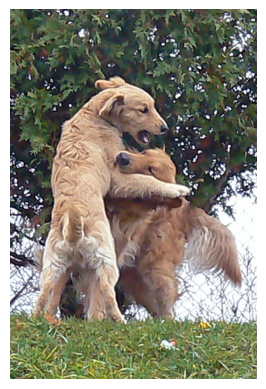

Reference label: Two brown dogs cavort together near a tree .
Generated captions:
Two brown dogs fighting with each other
Two short-haired dogs jumping .
Two dogs are fighting and biting each other .
Two dogs fighting in a forest
Two dogs fight in the grass .





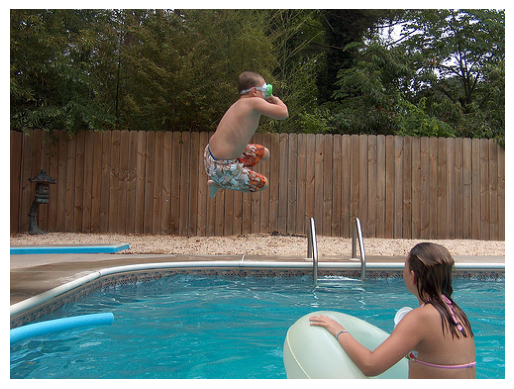

Reference label: A boy does a cannonball into a pool while a girl watches .
Generated captions:
A girl plays near a swimming pool while a boy in a mask jumps into the water .
A girl flipping into a swimming pool while a boy in a mask jumps in from the diving board .
Young girl with goggles jumping into a pool .
A man throws a little boy into a pool while a girl watches .
A girl runs through an inflatable pool .





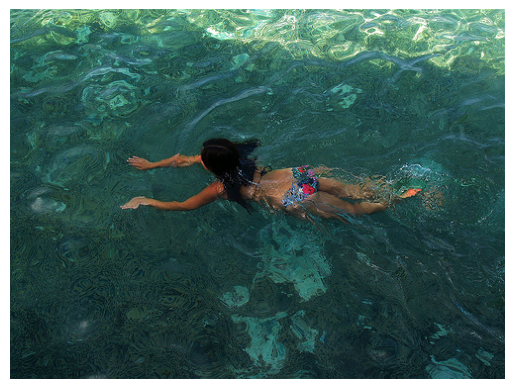

Reference label: A tan girl in a floral bikini is swimming in dark blue waters .
Generated captions:
A child swims in a sparkling blue pool .
The girl is swimming in sparkling greenish blue water .
A little girl in a bikini is swimming in a body of water .
A small girl swimming in a sparkling green lake .
Someone splashes in the water , the orange-green watermelon ball floats halfway .





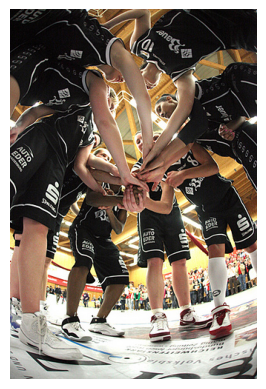

Reference label: A sports team is in a huddle with hands together .
Generated captions:
A sports team is in a huddle with hands together .
Players with black and orange shorts at a crowded indoor game .
Players wearing black
Hockey players in a huddle .
Players wearing black





In [29]:
# test
for i in range(5):
    # get random image
    idx = randint(0, len(dataset) - 1)
    img_path = os.path.join("/kaggle/input/flickr8k/Images", df.iloc[idx]['image'])
    display_image = Image.open(img_path).convert("RGB")
    
    # display image and reference label
    plt.imshow(display_image)
    plt.axis("off")
    plt.show()
    print(f"Reference label: {df.iloc[idx]['caption']}")
    
    # load the image tensor
    image, _, _ = dataset[idx]
    images = torch.stack([image for i in range(5)], dim=0).to(device)
    
    # generate captions
    captions = model.generate(
        images,
        tokenizer,
        do_sample = True
    )
    print(f"Generated captions:")
    for cap in captions:
        print(cap)
    print("\n\n")